![AiDress](img_notebook/aidresss.png)

# Introduction

## Un probleme qui compte

Chaque jour, des millions de photographies sont prises, envoyées, partagées. Elles sont au coeur de nombreux processus industriels pour lesquels ces images sont des elements fondamentaux de leur capacité à classer, mettre en avant et vendre leurs produits et services.

Les besoins de labelisations au sein des systemes d'information de ces acteurs, au rang desquels figurent les marketplaces type Amazon, Cdiscount mais aussi les plateformes publicitaires comme Gaoogle ou Critéo, sont enormes. Pour ces acteurs, il est impératif des categoriser des flux entraint de millions de données non-structurées auquel il faut donner un sens pour pouvoir les valoriser et les fructifiez.

Un exemple plus precis pourrait d'etre l'Universal Catalog utilisé au sein de Critéo qui constitue une taxonomie representant et stockant des millions de données envoyées par leurs clients pour generer des placements publicitaire. Le probleme fondamentale est le fait que ces flux sont tres mal annotés voir pas du tout ce qui rend la tache de les inclures dans une categorie precise de la taxonomie tres compliqué. Ceci a un impact crucial sur la capacité de Criteo à proposer la bonne annonce au bon moment.


Notre projet repond à ce besoin des plateformes et à ceux des marketplaces en général en proposant une application permettant l'annotation automatique de la catégorie de vetement à laquelle appartient une image illustant un habit à vendre.

Cette application prendra, pour un soucis de démonstration,la forme d'une web app qui permettra à l'utilisateur d'annoter l'image d'habillement de son choix, aussi bien sur mobile que sur laptop/desktop. Ce projet pourra evidemment s'intregrer au sein d'un back-end afin d'effectuer les annotations automatiquement. Un tel algorithme permettrait par exemple de mettre en place une classification centralisée et homogène pour tous les articles transitant par le Marketplace, sans engager d’efforts humain ou économique supplémentaires.


![Demo](img_notebook/web_app_demonstration.gif)

**la demonstration est accesible en live à l'adresse : https://aidress.onrender.com/**

## Structure du projet

Le projet se structure autour d'une démarche scientifique de bout en bout allant de l'acquisition des données à la mise en place d'un *proof-of-concept* valorisable, en passant par l'apprehension des données et le choix d'une modélisation usant les derniers standard de la recherche en Deep Learning.

1. Acquisition des données par Web Scraping des données
2. Statistiques descriptives sur ces données
3. Modelisation
4. Architecture de la web app

## Reproductibilité

L'ensemble des resultats présentés ci-dessous sont pensés dans l'optique de la reproducibilité.

À cet effet, le lecteur retrouvera dans le repertoire *reproduce_work* du dépot l'ensemble des instructions et des éléments lui permettant de reproduire notre travail.

## Tests

Vous pourrez retrouver une suite complete de tests pour les algorithmes de traitements statistiques des images au niveau du repertoire *utils/desc_stats/test_statistiques_descriptives.py*

# PARTIE 1 : Acquisition des données via Web Scraping

In [ ]:
from utils.scraping.data_scraping import scrap_garments

In [ ]:
# Vous pourrez executer cette cellule si vous souhaitez scraper les données
# il est possible d'aller directement au niveau de utils/scraping.data_scraping.py, specifier les chemins d'acces 
# et executer le module avec le terminal
# cette fonction comme toutes les autres est documentée

garment_classes = ['tshirt','pantalon','pull','short']
save_path = 'yourpath'
chromedriver_path = 'yourpath'
scrap_garments(garment_classes,save_path,chromedriver_path)

# PARTIE 2 : Statistiques descriptives


Dans un premier temps, menons une étude statistique sur la base de donnée que nous avons collectée.


## 0) Mise en place de l'espace de travail

Nous importons les données.

Pour démarrer, renseignez la variable path ci-dessous, en y inscrivant le chemin menant au dataset sur votre ordinateur.

In [14]:
path = "C:/Users/wawa_/Downloads/python_project_dataset/python_project_dataset"

Ensuite, chargeons chaque classe de données dans une variable au nom de la classe.

In [15]:
import os
pull = os.listdir(path=path+'/pull')
tshirt = os.listdir(path=path+'/tshirt')
short = os.listdir(path=path+'/short')
pantalon = os.listdir(path=path+'/pantalon')

Chacune de ces variables ne contient que le nom des images. Par exemple, pull[0] = 'h0015147760549918.jpg'. 

Ainsi, pour avoir accès au premier pull du dataset il faut faire la commande suivante :



```
path + '/pull/' + pull[0]
```



Jetons un coup d'oeil à nos donéees. On génère 2 images aléatoirement par classe à l'aide de la fonction **two_random_images**  :

In [ ]:
?two_random_images

In [ ]:
two_random_images('pull')
two_random_images('tshirt')
two_random_images('short')
two_random_images('pantalon')

## 1) Premières statistiques


Nous pouvons alors avoir de premières statistiques, comme la distribution des tailles de fichiers :

In [ ]:
?first_stats

In [ ]:
first_stats()

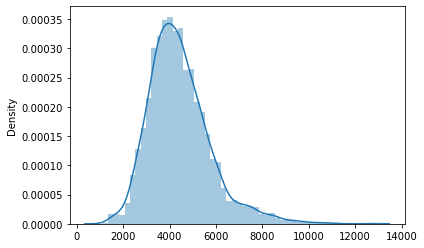

Étonnement, cette distribution semble suivre une loi normale !

Statistique sur la répartitions des catégories de vêtements de la base de données :



In [ ]:
?pie_chart_categories()

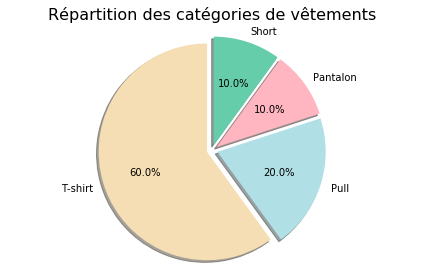

In [16]:
pie_chart_categories()

On remarque ainsi une large sur-représentation de T-shirts dans la base de donnée, dû sans doute à une prédominance de ces articles sur le commerce de vêtements en ligne.


## 2) Une couleur prédominante ?

Dans cette sous-partie, nous allons analyser la repartition de la couleur majoritaire de chaque vêtements par classe. Nous nous restreignons aux 12 couleurs suivantes : Blanc, Noir, Gris, Rouge, Marron, Jaune, Vert, Cyan, Bleu, Violet, Rose. Par exemple, pour tous les pulls, nous allons compter le nombre de pulls blancs, noirs, gris etc... Pour les vêtements qui ont plusieurs couleurs, nous prendrons en compte la couleur majoritaire. 

Pour ce faire, nous allons utiliser trois fonctions similaires (**colour_repartition_mean**, **colour_reparition_cluster**, **colour_repartition_major**) mais qui utilisent trois méthodes différentes ("mean", "cluster", "major") qui seront expliqués un peu plus loin. 

Chacune des ces fonctions utilisent la fonction "**major_colour**" qui, étant donné un triplet rgb donne la couleur la plus proche (parmis les couleurs citées précédemment) au sens de la distance euclidienne. Avant le traitement de l'image par ces fonctions, nous zoomons l'image afin de ne plus avoir les couleurs environnante (en particulier le blanc du fond) et nous concentrer sur la couleur du vêtement en elle-même. Nous utiliserons alors sans distinction "couleur de l'image" et "couleur du vêtement" dans la suite.

### a) Méthode "mean"

La première méthode utilisée est celle que nous avons nommé "mean". C'est la méthode la plus naive. Il s'agit de faire la moyenne de la matrice RGB de tous les pixels de sorte à avoir le triplet (r,g,b) moyen de l'image. On calcule ensuite la couleur la plus proche grace à la fonction "major_colour".

In [ ]:
?colour_repartition_mean

Object `colour_repartition_mean` not found.


In [ ]:
pull_colours_mean = colour_repartition_mean('pull', percentage = 1)
tshirt_colours_mean = colour_repartition_mean('tshirt', percentage = 1)
pantalon_colours_mean = colour_repartition_mean('pantalon', percentage = 1)
short_colours_mean = colour_repartition_mean('short', percentage = 1)

Les variables que nous venont de créer sont des dictionnaires dont les clés sont des couleurs et dont les valeurs comptabilisent le nombre de vêtements de la même couleur que la clé associée.

Par exemple, la dernière ligne nous donne 

```
# {'Blanc': 14,
 'Noir': 40,
 'Gris': 181,
 'Rouge': 5,
 'Marron': 15,
 'Jaune': 1,
 'Vert': 1,
 'Cyan': 2,
 'Bleu': 40,
 'Violet': 57,
 'Rose': 2}
```

Il y a donc 14 shorts blancs, 40 shorts bleus etc...


On peut alors tracer un histogramme du nombre de couleurs pour chaque classe.

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(20,10))
plt.suptitle('Repartition des couleurs avec la méthode colour_repartition_mean', fontsize=20)
plt.subplot(221)
sns.barplot(y=list(pull_colours_mean.keys()), 
            x=list(pull_colours_mean.values()), 
            palette=['white','black', 'grey', 'red', 'brown', 'yellow','green', 'cyan', 'blue', 'purple', 'pink'],
            linewidth=0.5,
            edgecolor='black')
plt.title('Pulls')

plt.subplot(222)
sns.barplot(y=list(short_colours_mean.keys()), 
            x=list(short_colours_mean.values()), 
            palette=['white', 'black', 'grey', 'red', 'brown', 'yellow','green', 'cyan', 'blue', 'purple', 'pink'],
            linewidth=0.5,
            edgecolor='black')
plt.title('Shorts')

plt.subplot(223)
sns.barplot(y=list(pantalon_colours_mean.keys()), 
            x=list(pantalon_colours_mean.values()), 
            palette=['white','black','grey', 'red', 'brown', 'yellow','green', 'cyan', 'blue', 'purple', 'pink'],
            linewidth=0.5,
            edgecolor='black')
plt.title('Pantalons')

plt.subplot(224)
sns.barplot(y=list(tshirt_colours_mean.keys()), 
            x=list(tshirt_colours_mean.values()), 
            palette=['white','black', 'grey', 'red', 'brown', 'yellow','green', 'cyan', 'blue', 'purple', 'pink'],
            linewidth=0.5,
            edgecolor='black')
plt.title('Tshirts')

Les resultats peuvent être long à obtenir lorsque "percentage=1", nous affichons les histogrammes obtenus avec toute la base de donnée ci-après.

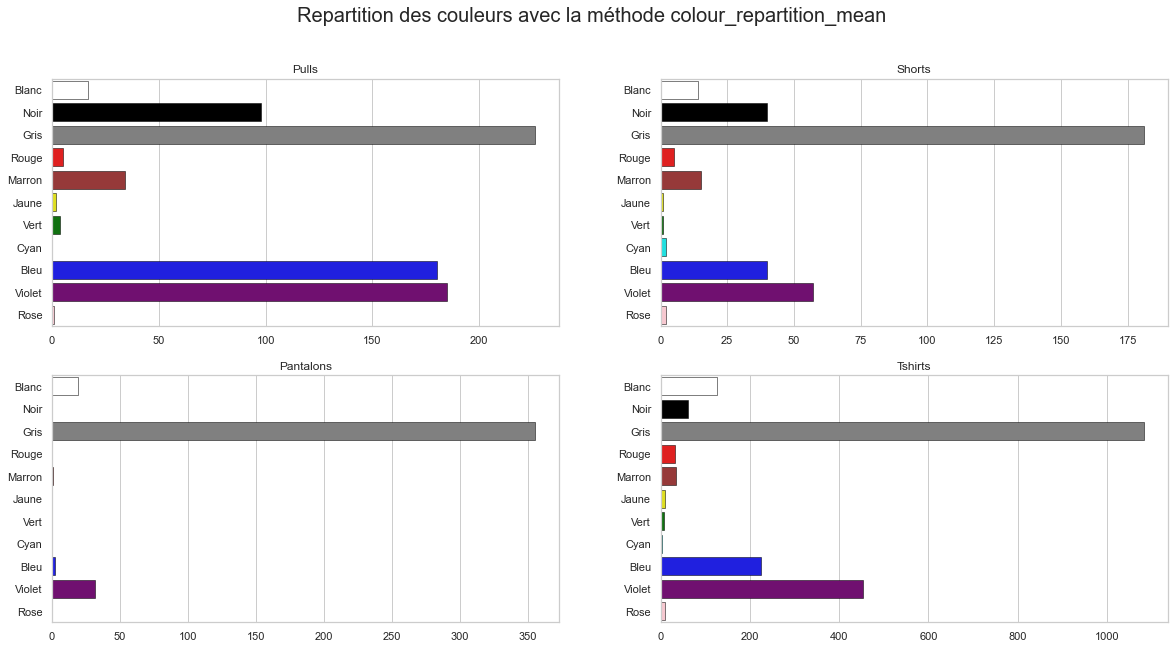

On remarque que le gris est plutôt majoritaire. Cela est causé par la méthode employée. En effet, faire une moyenne du RGB de tous les pixels est susceptible de nous donner un triplet (r,g,b) tels que r,g et b soient plutôt proche, ce qui correspond à du gris. Ce problème est resolu par la méthode suivante.

## b) Méthode "major"

La méthode major repose sur le principe suivant : on determine la couleur la plus proche de chaque pixel d'une image à l'aide de "**major_colour**". La couleur qui a le plus de pixel associé est designée comme la couleur du vêtement. Les variables suivantes sont crées d'une façon similaire à celles précédemment crées.

In [ ]:
?colour_repartition_major

In [ ]:
pull_colours_major = colour_repartition_major('pull', percentage=1)
tshirt_colours_major = colour_repartition_major('tshirt', percentage=1)
pantalon_colours_major = colour_repartition_major('pantalon', percentage=1)
short_colours_major = colour_repartition_major('short', percentage=1)

**Attention** : la cellule prend plusieurs heures pour se lancer, il est donc préférable de changer la variable percentage (qui règle le pourcentage du dataset à charger dans l'utilisation de la fonction) à 0.1 voire 0.01.

On peut tracer les histogrammes pour chaque classe.

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(20,10))
plt.suptitle('Repartition des couleurs avec la méthode colour_repartition_major', fontsize=20)
plt.subplot(221)
sns.barplot(y=list(pull_colours_major.keys()), 
            x=list(pull_colours_major.values()), 
            palette=['white','black', 'grey', 'red', 'brown', 'yellow','green', 'cyan', 'blue','purple', 'pink'],
            linewidth=0.5,
            edgecolor='black')
plt.title('Pulls')

plt.subplot(222)
sns.barplot(y=list(short_colours_major.keys()), 
            x=list(short_colours_major.values()), 
            palette=['white', 'black', 'grey', 'red', 'brown', 'yellow','green', 'cyan', 'blue', 'purple', 'pink'],
            linewidth=0.5,
            edgecolor='black')
plt.title('Shorts')

plt.subplot(223)
sns.barplot(y=list(pantalon_colours_major.keys()), 
            x=list(pantalon_colours_major.values()), 
            palette=['white','black','grey', 'red', 'brown', 'yellow','green', 'cyan', 'blue', 'purple', 'pink'],
            linewidth=0.5,
            edgecolor='black')
plt.title('Pantalons')

plt.subplot(224)
sns.barplot(y=list(tshirt_colours_major.keys()), 
            x=list(tshirt_colours_major.values()), 
            palette=['white','black', 'grey', 'red', 'brown', 'yellow','green', 'cyan', 'blue', 'purple', 'pink'],
            linewidth=0.5,
            edgecolor='black')
plt.title('Tshirts')

Pour les mêmes raisons que précédemment, nous affichons les graphiques obtenus avec l'ensemble de la base de donées.

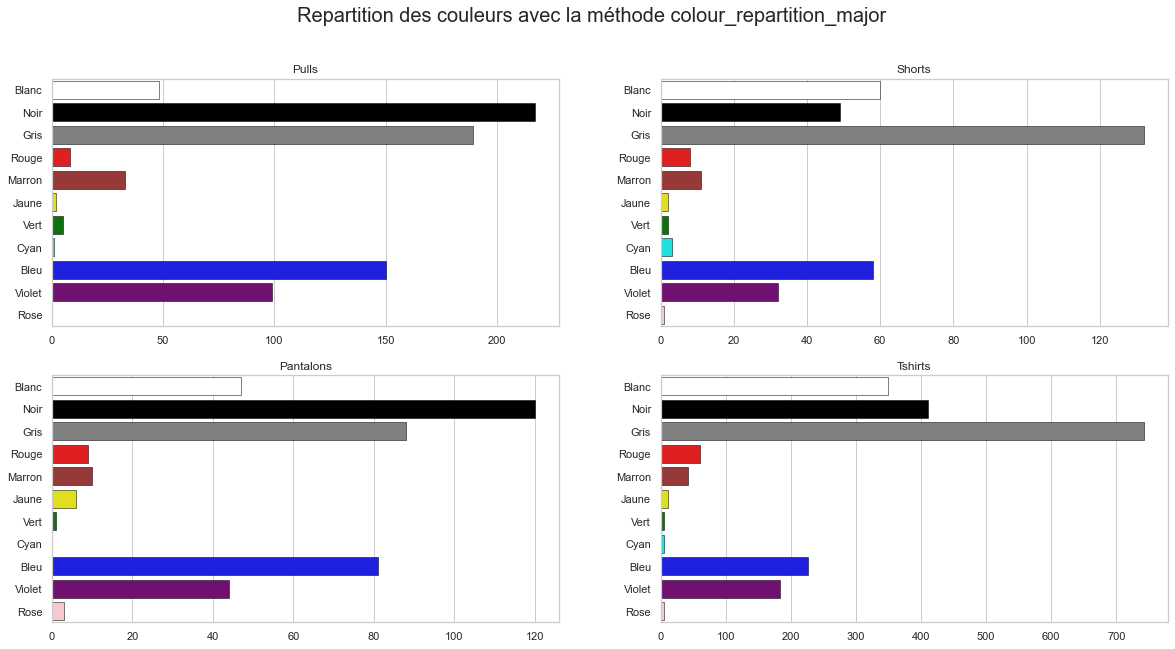

On remarque que le problème précédent semble réglé : dans deux cas sur trois, le gris n'est plus la couleur majoritaire. Le gris reste cependant assez prédominant (ainsi que le blanc et le noir) mais cela est dû au fait que la majorité des vêtements sont d'une de ces trois couleurs.

## c) Méthode "cluster"

Cette méthode est basé sur l'algorithme des k-means. Nous choisissons le nombre de cluster égal à 2 car après quelques essais, cela semble être le plus efficace. Cela reste cependant arbitraire, étant donné que ce n'est pas le coeur du projet et que cette partie nous permet surtout d'avoir une première idée du dataset, nous n'avons pas poussé l'optimisation au maximum.

In [ ]:
?colour_repartition_cluster

In [ ]:
pull_colours_cluster = colour_repartition_cluster('pull', percentage=1, ncluster=2)
tshirt_colours_cluster = colour_repartition_cluster('tshirt',percentage=1, ncluster=2)
pantalon_colours_cluster = colour_repartition_cluster('pantalon', percentage=1, ncluster=2)
short_colours_cluster = colour_repartition_cluster('short', percentage=1, ncluster=2)

Ainsi que les histogrammes correspondants.

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(20,10))
plt.suptitle('Repartition des couleurs avec la méthode colour_repartition_cluster', fontsize=20)
plt.subplot(221)
sns.barplot(y=list(pull_colours_cluster.keys()), 
            x=list(pull_colours_cluster.values()), 
            palette=['white','black', 'grey', 'red', 'brown', 'yellow','green', 'cyan', 'blue', 'purple', 'pink'],
            linewidth=0.5,
            edgecolor='black')
plt.title('Pulls')

plt.subplot(222)
sns.barplot(y=list(short_colours_cluster.keys()), 
            x=list(short_colours_cluster.values()), 
            palette=['white', 'black', 'grey', 'red', 'brown', 'yellow','green', 'cyan', 'blue','purple', 'pink'],
            linewidth=0.5,
            edgecolor='black')
plt.title('Shorts')

plt.subplot(223)
sns.barplot(y=list(pantalon_colours_cluster.keys()), 
            x=list(pantalon_colours_cluster.values()), 
            palette=['white','black','grey', 'red', 'brown', 'yellow','green', 'cyan', 'blue','purple', 'pink'],
            linewidth=0.5,
            edgecolor='black')
plt.title('Pantalons')

plt.subplot(224)
sns.barplot(y=list(tshirt_colours_cluster.keys()), 
            x=list(tshirt_colours_cluster.values()), 
            palette=['white','black', 'grey', 'red', 'brown', 'yellow','green', 'cyan', 'blue', 'purple', 'pink'],
            linewidth=0.5,
            edgecolor='black')
plt.title('Tshirts')

Enfin, les histogrames obtenus pour la base de données complète.

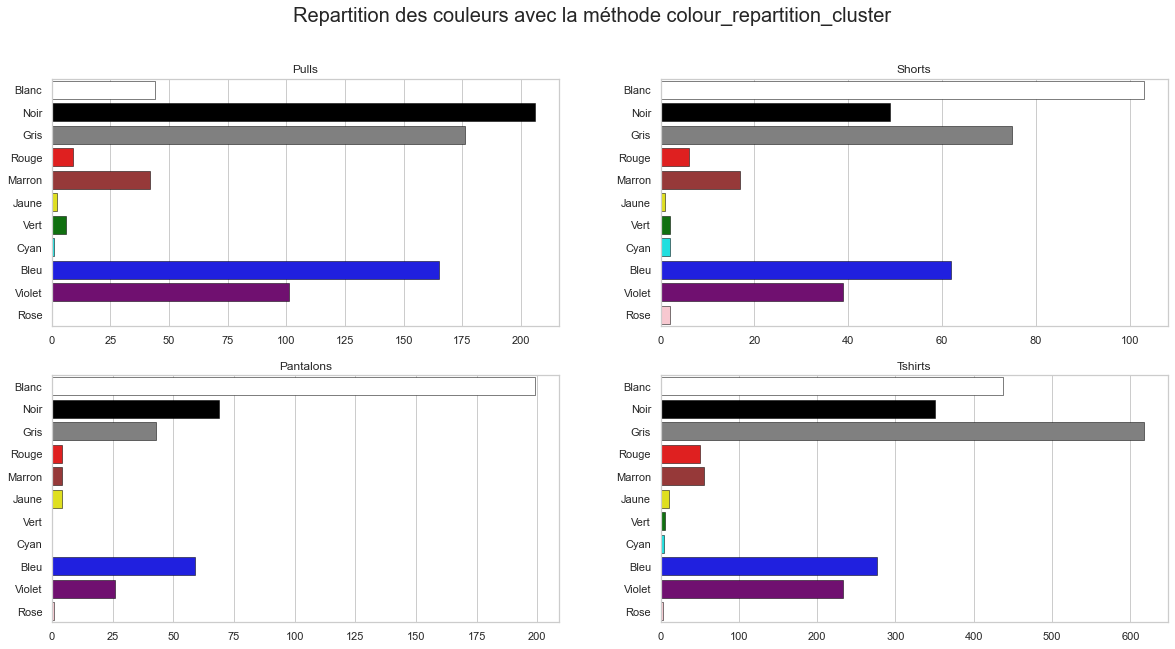

La quantité de vêtements gris a diminué, mais on note une recrudescence des vêtements de couleur blanche. On remarque c'est le cas surtout pour les shorts et les pantalons : le zoom de l'image qui nous permet de nous debarasser du fond blanc fonctionne moins bien sur les shorts et les pantalons (vu la disposition de ces derniers), ce qui peut expliquer la grande quantité de vêtements considérés comme blancs.

In [ ]:
?od.detectObjectsFromImage

## 3) Les habits font-ils fond blanc ?

Nous nous sommes intéressés aux couleurs de vêtements qui prédominaient, cependant il pourrait être tout autant intéressant de se pencher sur une question de fond, et en particulier de fond blanc ; quel pourcentage de la base de donnée représentent les vêtements ayant été pris en photo sur fond blanc ? Ces derniers sont particulièrement intéressants, en ce qu'ils fournissent un cadre d'apprentissage homogène pour l'algorithme, exempts de tout bruit extérieur.

Pour les besoins de cette partie, nous allons importer toutes les images de la base de données dès maintenant.

In [ ]:
target_size = (256,256) 
data_pull = []
data_tshirt = []
data_pantalon = []
data_short = []
data_all = []

time1 = time.time()
compteur_1=0

for i in range(len(pull)):  
    data_pull.append(load_img(path + "/pull/" + pull[i],target_size=target_size))
    compteur_1+=1
    
for i in range(len(tshirt)):  
    data_tshirt.append(load_img(path + "/tshirt/" + tshirt[i],target_size=target_size))
    compteur_1+=1
    
for i in range(len(pantalon)):  
    data_pantalon.append(load_img(path + "/pantalon/" + pantalon[i],target_size=target_size))
    compteur_1+=1
    
for i in range(len(short)):  
    data_short.append(load_img(path + "/short/" + short[i],target_size=target_size))
    compteur_1+=1

data_all = data_pull + data_tshirt + data_pantalon + data_short

print("Importation terminée. L'importation des {} images a duré {} secondes".format(compteur_1,time.time()-time1))    

Importation terminée. L'importation des 3571 images a duré 3.563572645187378 secondes


Certains algorithmes n'ont pas besoin de photos de bonne qualité, nous allons donc également créer des listes de photo en (très) basse résolution.

In [ ]:
target_size = (50,50) 
data_pull_lowres = []
data_tshirt_lowres = []
data_pantalon_lowres = []
data_short_lowres = []
data_all_lowres = []

time1 = time.time()
compteur_1=0

for i in range(len(pull)):  
    data_pull_lowres.append(load_img(path + "/pull/" + pull[i],target_size=target_size))
    compteur_1+=1
    
for i in range(len(tshirt)):  
    data_tshirt_lowres.append(load_img(path + "/tshirt/" + tshirt[i],target_size=target_size))
    compteur_1+=1
    
for i in range(len(pantalon)):  
    data_pantalon_lowres.append(load_img(path + "/pantalon/" + pantalon[i],target_size=target_size))
    compteur_1+=1
    
for i in range(len(short)):  
    data_short_lowres.append(load_img(path + "/short/" + short[i],target_size=target_size))
    compteur_1+=1

data_all_lowres = data_pull_lowres + data_tshirt_lowres + data_pantalon_lowres + data_short_lowres

print("Importation terminée. L'importation des {} images a duré {} secondes".format(compteur_1,time.time()-time1))    

Importation terminée. L'importation des 3571 images a duré 2.9346702098846436 secondes


Nous utilisons une méthode de reconnaissance pixel par pixel. Afin de déterminer si un pixel donné est blanc ou non, nous allons considérer une notion de **threshold** et une notion de **distance** : si les trois coordonnées rgb du pixel sont assez proches de 256 (*i.e.* dépassent tous les trois une limite qu'on a définie arbitrairement, un threshold) et sont assez proche en terme de distance euclidienne (pour ne pas avoir de couleur prédominante), alors on considérera que le pixel donné est blanc. La fonction effectuant ce travail est la fonction **is_white**.

In [ ]:
?is_white

Pour déterminer si une image est sur fond blanc, nous allons intégrer le calcul ci-dessus sur tous les pixels de la photo via la fonction **is_white_background**. Si le pourcentage de pixels blancs dépasse un certain seuil (défini sur 30% par défaut), alors l'image sera considérée comme étant sur fond blanc, et la fonction renverra *True*.

In [ ]:
?is_white_background

Pour généraliser ce calcul à toutes les photos de la base de donnée et déterminer la fraction de photos sur fond blanc, nous allons utiliser la fonction **percentage_true** (qui reviendra plusieurs fois dans les parties qui viennent), qui prend en argument une base de données d'images ainsi qu'une fonction booléenne, et qui renvoie le pourcentage d'images de la base de données pour lesquelles la fonction booléenne renvoie *True*.

In [ ]:
?percentage_true

En l'occurence, si on applique percentage_true à notre base de données d'images et à la fonction is_white_background, nous obtiendrons le pourcentage d'images ayant un fond blanc.  

Avant cela, nous aimerions montrer un aperçu de l'algorithme via les fonctions **is_white_background_feedback** et **percentage_true_feedback**.  
(De manière générale, les fonctions **x**\_feedback fonctionnent de la même manière que les fonctions originelles **x**, mais fournissent un retour utilisateur supplémentaire).

In [ ]:
?is_white_background_feedback

In [ ]:
?percentage_true_feedback

Prévisualisons donc l'algorithme sur trois images de chaque base de données :

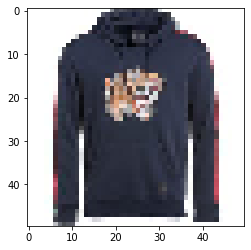

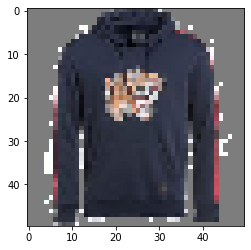

FOND BLANC. Pourcentage de pixels blancs :  32.32


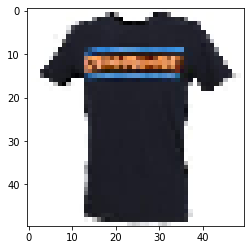

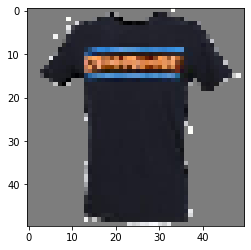

FOND BLANC. Pourcentage de pixels blancs :  47.0


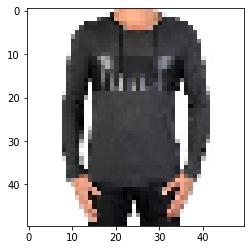

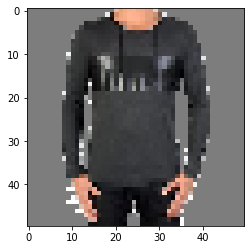

FOND BLANC. Pourcentage de pixels blancs :  43.96


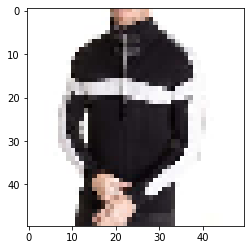

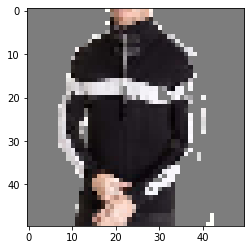

FOND BLANC. Pourcentage de pixels blancs :  51.160000000000004


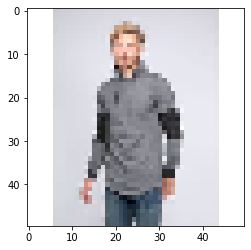

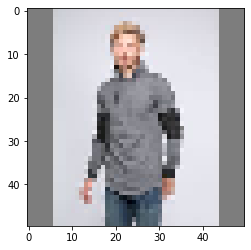

PAS DE FOND BLANC. Pourcentage de pixels blancs :  24.04


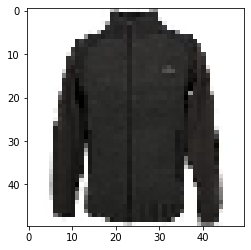

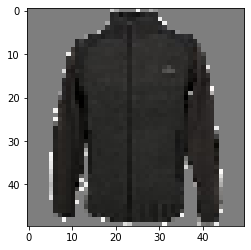

FOND BLANC. Pourcentage de pixels blancs :  36.720000000000006


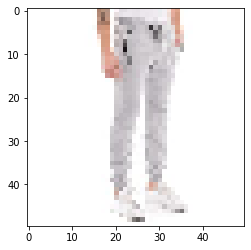

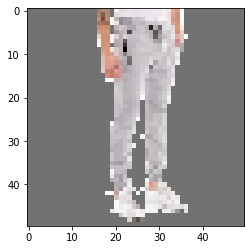

FOND BLANC. Pourcentage de pixels blancs :  73.36


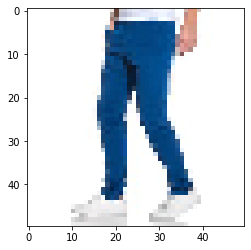

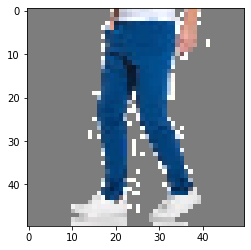

FOND BLANC. Pourcentage de pixels blancs :  65.84


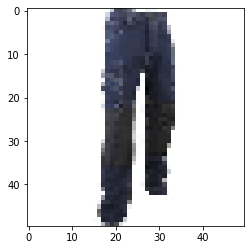

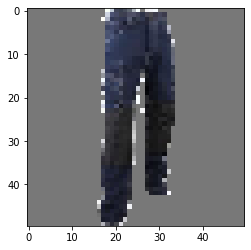

FOND BLANC. Pourcentage de pixels blancs :  73.44000000000001


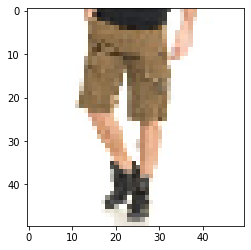

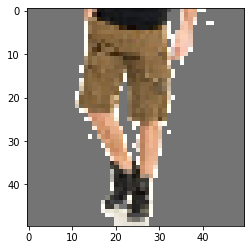

FOND BLANC. Pourcentage de pixels blancs :  66.60000000000001


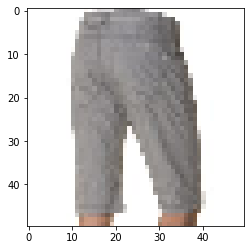

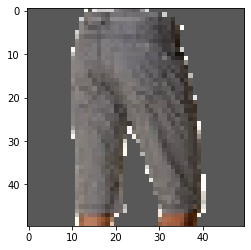

FOND BLANC. Pourcentage de pixels blancs :  49.8


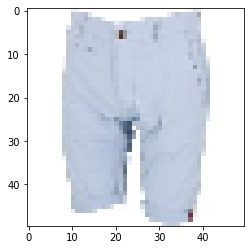

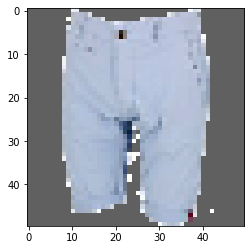

FOND BLANC. Pourcentage de pixels blancs :  42.32
Dans l'échantillon donné, il y a 91.66666666666666 % de photos sur fond blanc.


In [ ]:
tshirt_sample = random.sample(data_tshirt_lowres,3)
pull_sample = random.sample(data_pull_lowres,3)
pantalon_sample = random.sample(data_pantalon_lowres,3)
short_sample = random.sample(data_short_lowres,3)
sample = tshirt_sample + pull_sample + pantalon_sample + short_sample


pourcent_sample =  percentage_true_feedback(sample, is_white_background_feedback)
print("Dans l'échantillon donné, il y a",pourcent_sample ,"% de photos sur fond blanc.")

Le gris sur les images sert à montrer à l'utilisateur quels pixels ont été considérés comme blancs ou non par notre algorithme. Nous pouvons également nous limiter à l'usage des images très faible résolution (**50x50**) pour ce qui est de l'établissement d'un pourcentage. Cela augmente drastiquement la vitesse de l'algorithme, pour des pertes négligeables

Ceci dit, certaines images sont sur fond blanc écru ou gris, que notre algorithme va naïvement ignorer : elles ne seront pas considérés comme fond blanc. Nous pourrions les y inclure, en augmentant la permission avec lequel un pixel est considéré comme "blanc", mais cela aurait pour effet de considérer certains T-shirts blancs comme faisant partie du fond. Nous avons donc réalisé un arbitrage entre ces deux effets contraires, en jouant sur les valeurs du threshold et de la distance. L'efficacité d'un tel algorithme ne sera jamais de 100%, mais elle est bien assez grande pour établir une statistique fiable sur la répartition des photos sur fond blanc ou non. 

Voici ci-dessous l'ensemble des résultats que nous obtenons :

In [ ]:
#Environ 2 minutes d'exécution. Vous pouvez retrouver les résultats que nous avons déjà calculé dans 
#la cellule en dessous.

print("Pourcentage de T-shirts sur fond blanc :\n")
percentage_white_background_tshirt = percentage_true(data_tshirt_lowres, is_white_background)
print("Il y a", percentage_white_background_tshirt ,"% de T-shirts sur fond blanc.\n")

print("Pourcentage de Pulls sur fond blanc :\n")
percentage_white_background_pull = percentage_true(data_pull_lowres, is_white_background)
print("Il y a", percentage_white_background_pull ,"% de Pulls sur fond blanc.\n")

print("Pourcentage de Shorts sur fond blanc :\n")
percentage_white_background_short = percentage_true(data_short_lowres, is_white_background)
print("Il y a", percentage_white_background_short ,"% de Shorts sur fond blanc.\n")

print("Pourcentage de Pantalons sur fond blanc :\n")
percentage_white_background_pantalon = percentage_true(data_pantalon_lowres, is_white_background)
print("Il y a", percentage_white_background_pantalon ,"% de Pantalons sur fond blanc.\n")

print("Pourcentage total d'habits sur fond blanc :\n")
percentage_white_background_all = 1/len(data_all_lowres) * (percentage_white_background_tshirt * len(data_tshirt_lowres) + percentage_white_background_pull * len(data_pull_lowres) + percentage_white_background_short * len(data_short_lowres) + percentage_white_background_pantalon * len(data_pantalon_lowres))
print("Il y a au total", percentage_white_background_all ,"% d'habits sur fond blanc.\n")

Pourcentage de T-shirts sur fond blanc :

200 images. Nous en sommes à : 9.77 % d'avancement.
400 images. Nous en sommes à : 19.54 % d'avancement.
600 images. Nous en sommes à : 29.31 % d'avancement.
800 images. Nous en sommes à : 39.08 % d'avancement.
1000 images. Nous en sommes à : 48.85 % d'avancement.
1200 images. Nous en sommes à : 58.62 % d'avancement.
1400 images. Nous en sommes à : 68.39 % d'avancement.
1600 images. Nous en sommes à : 78.16 % d'avancement.
1800 images. Nous en sommes à : 87.93 % d'avancement.
2000 images. Nous en sommes à : 97.7 % d'avancement.
Il y a 88.5686370297997 % de T-shirts sur fond blanc.

Pourcentage de Pulls sur fond blanc :

200 images. Nous en sommes à : 26.49 % d'avancement.
400 images. Nous en sommes à : 52.98 % d'avancement.
600 images. Nous en sommes à : 79.47 % d'avancement.
Il y a 85.1655629139073 % de Pulls sur fond blanc.

Pourcentage de Shorts sur fond blanc :

200 images. Nous en sommes à : 55.87 % d'avancement.
Il y a 69.55307262569832 %

Au total, après calcul, nous avons trouvé **89%** de T-Shirts sur fond blanc, **85%** de Pulls sur fond blanc, **70%** de Shorts sur fond blanc, **89%** de Pantalons sur fond blanc, pour un total de **86%** photos sur fond blanc. Il y a une légère différence sur le taux de Shorts sur fond blanc avec le reste des habits (qui pourrait être dû à notre algorithme grossier tout comme à la base de données), mais globalement les images sur fond blanc restent très dominantes sur l'ensemble des photos.



Il semblerait donc que cette base de données fournit un cadre idoine à l'apprentissage d'un algorithme de Deep Learning de ce point de vue. Et c'est sans compter encore une fois sur les photos sur fond gris qui ont été ignorées par notre algorithme naïf ci-dessus, mais qui ne tromperons par un algorithme plus développé.

In [ ]:
?pie_chart_logo

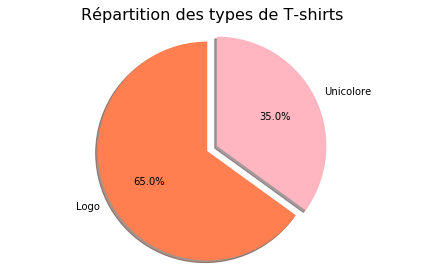

In [11]:
pie_chart_logo ()

## 4 )    Le cas particulier des T-Shirts : statistique sur les logos

Nous allons désormais nous intéresser à une nouvelle statistique sur un paramètre qui pourrait avoir un impact sur l'apprentissage de l'algorithme : la présence de logos. Leur forme, leur couleur et leur texture peut totalement varier d'un T-shirt à l'autre, il pourraît alors être intéressant de reconnaître quelle fraction de la base de donnée représentent ces T-shirts à logo. 

On va procéder par une méthode purement calculatoire ici ; par définition, un logo est une variation de couleur, de texture, au sein du T-shirt. A contrario, un T-shirt unicolor n'est, comme son nom l'indique, que d'une seule couleur.

On peut traduire l'assertion précédente par une propriété locale, en s'intéressant à chaque pixel **p** du t-shirt. Pour un pixel **p** donné, si les pixel environnant sont (à peu près) de même couleur, alors on peut supposer qu'il ne fait pas partie d'un logo. A contrario, s'il y a une grande variance autour d'un pixel du t-shirt, alors soit il est au bord du t-shirt (et la variation est dûe au fond de la photo), soit il fait partie d'un logo. Dans un premier temps, on considérera le premier effet cité comme *négligeable*, lorsqu'on agrège les variances de couleur de chaque pixel, c'est un effet de "bord" qui n'aura d'impact qu'en *une dimension*, alors que l'effet du logo sera en *deux dimensions*. Néanmoins, pour limiter d'autant plus cet impact, nous prendrons le soin d'effectuer un *zoom* au préalable sur chaque photo, de façon à isoler au maximum le T-Shirt du fond.

On formalise ici les notions de variance de couleur de chaque pixel. On définit d'abord une métrique de moyenne, la moyenne de couleur d'un pixel étant la moyenne de sa couleur à lui et des 8 pixels concomitants. 

<ins>Exemple</ins> : 
<img src="https://i.imgur.com/tKTPqyB.png" style="height:350px"> 

In [ ]:
?colour_mean

Puis la variance en découle : 
<img src="https://i.imgur.com/Oe5lG0l.png" style="height:350px">

(Par ailleurs, nous utilisons le mot "variance" pour son côté évocateur, mais en pratique nous avons plutôt considéré l'écart-type qui permet de conserver une homogénéité des valeurs, sur la plage [0,255].)

On obtient dans ce cas-là un écart-type faible entre les couleurs; en effet, on remarque à l'œil nu qu'elles sont toutes plus ou moins proches dans le spectre. En résulte donc un pixel de variance proche du noir. A contrario, si les couleurs des 9 pixels en questions varient fortement (ce qu'on pourrait trouver dans un logo, typiquement), le pixel résultant de l'algorithme sera très proche du blanc. 

<img src="https://i.imgur.com/GcSBHMJ.png" style="height:320px"> 

In [ ]:
?colour_var

Nous allons donc utiliser cette dernière fonction pour créer une version "topographique" de chaque image dans laquelle seules les variations de couleur sont mises en évidence. Chaque pixel d'une image se verra attribué une variance, puis nous allons sommer la variance de chacun de ces pixels pour attribuer un "score" de logo à la photo. Si ce score dépasse un certain seuil (défini arbitrairement là encore), alors l'image du T-shirt sera considérée comme comportant un logo. La fonction **is_logo** met en œuvre tout le processus résumé ci-dessus. Il dit si pour un T-shirt donné, ce T-shirt contient un logo ou non. Cette dernière fonction étant une fonction booléenne, là encore, nous allons avoir recours à la fonction **percentage_true** pour déterminer la fraction des T-shirts comportant un logo.

In [ ]:
?is_logo

In [ ]:
?percentage_true

Mais là encore, visualisons l'effet de l'algorithme avant toute chose avec les fonctions **is_logo_feedback** et **percentage_true_feedback** (qui pour rappel font la même chose que les fonctions originelles, en plus de fournir un retour image à l'utilisateur).

In [ ]:
?is_logo_feedback

In [ ]:
?percentage_true_feedback

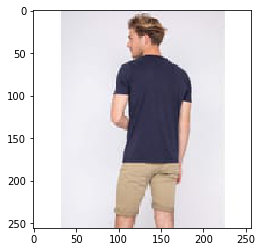

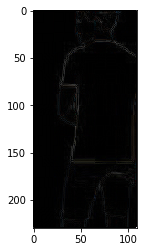

PAS DE LOGO. Score : 12.450742827388664


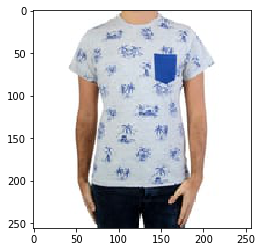

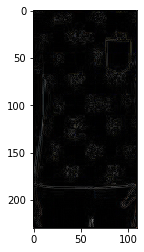

LOGO. Score : 13.030842210216871


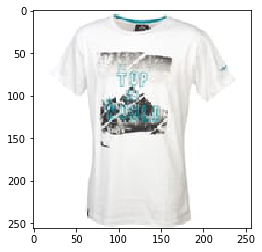

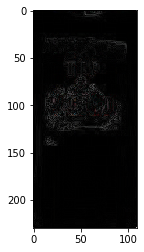

LOGO. Score : 12.78697175670736


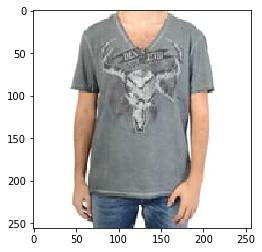

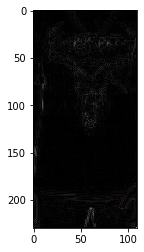

LOGO. Score : 12.864605089123772


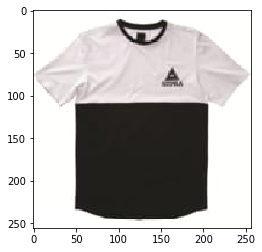

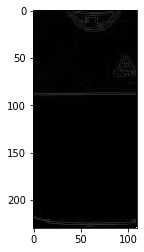

PAS DE LOGO. Score : 12.11382576901773


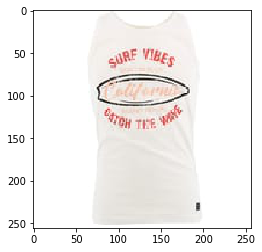

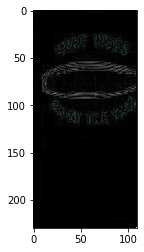

LOGO. Score : 12.956736092559844


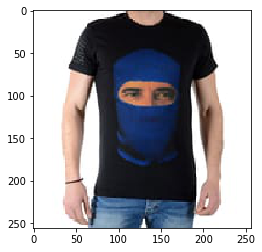

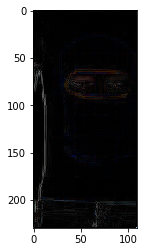

LOGO. Score : 12.73651264357974


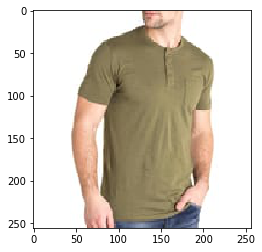

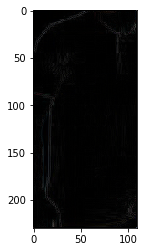

PAS DE LOGO. Score : 12.278681637631584
Dans l'échantillon donné, il y a 62.5 % de T-shirts à logo.


In [ ]:
tshirt_sample = random.sample(data_tshirt,8)

pourcent_sample =  percentage_true_feedback(tshirt_sample, is_logo_feedback)
print("Dans l'échantillon donné, il y a",pourcent_sample ,"% de T-shirts à logo.")

En noir apparaissent les images de variances, sur lesquelles seules les variations de couleur ressortent (en blanc).

Comme vous pouvez le voir, l'algorithme ci-dessus n'a pas une efficacité parfaite, il reconnaît parfois la silhouette d'un mannequin comme étant une variation de couleur, *i.e.* un logo dans notre cas (sur les photos dans lesquelles le zoom n'a pas été suffisant), ce qui peut le pousser à prendre un T-shirt unicolor comme un T-shirt à logo. D'autres fois, c'est l'inverse qui se produit car la couleur du logo est trop proche de la couleur du T-shirt.

Néanmoins, l'algorithme fournit des résultats très satisfaisant vis-à-vis de sa simplicité. La marge d'erreur, même si elle existe, reste relativement faible ; ce qui nous intéresse, c'est estimer une statistique globale sur la base de donnée, ce que cette fonction permet très convenablement.

Voici ci-dessous l'exécution de l'algorithme permettant l'obtention de ce paramètre. Cette fois-ci, nous sommes obligés de travailler sur des photos à bonne résolution (**256x256**), car cet algorithme est très sensible au bruit.

In [ ]:
#Environ 10 minutes d'exécution. Vous pouvez retrouver les résultats que nous avons déjà calculé dans 
#la cellule en dessous.

print("Pourcentage de T-shirts à logo :\n")
percentage_logo_tshirt = percentage_true(data_tshirt, is_logo)
print("Il y a", percentage_logo_tshirt ,"% de T-shirts à logo.\n")


Pourcentage de T-shirts à logo :

200 images. Nous en sommes à : 9.77 % d'avancement.
400 images. Nous en sommes à : 19.54 % d'avancement.
600 images. Nous en sommes à : 29.31 % d'avancement.
800 images. Nous en sommes à : 39.08 % d'avancement.
1000 images. Nous en sommes à : 48.85 % d'avancement.
1200 images. Nous en sommes à : 58.62 % d'avancement.
1400 images. Nous en sommes à : 68.39 % d'avancement.
1600 images. Nous en sommes à : 78.16 % d'avancement.
1800 images. Nous en sommes à : 87.93 % d'avancement.
2000 images. Nous en sommes à : 97.7 % d'avancement.
Il y a 65.0219833903273 % de T-shirts à logo.



In [ ]:
?pie_chart_fond_blanc

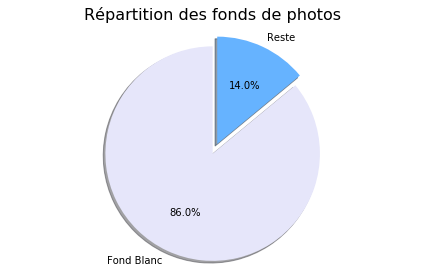

In [9]:
pie_chart_fond_blanc()

Au total, après calcul, nous avons trouvé **65%** de T-Shirts à logo, ce qui représente une part non-négligeable de la base de donnée qu'il conviendra de prendre en compte avant de juger les performances de notre algorithme de reconnaissance d'image.

## 5 ) Premier pas vers le Deep Learning : statistique sur les mannequins

Pour conclure cette partie de Statistique Descriptive, nous allons faire un premier pas vers le Deep Learning en nous intéressant à la proportion de photos comportant un mannequin humain. En effet, ce paramètre est complexe et très compliqué à estimer avec un algorithme classique ; une caractéristique de couleur ou de variance ne permet plus de trancher sur le résultat.

Pour ce faire, nous allons nous baser sur les bibliothèques [opencv](https://opencv.org/) et [ImageAI](http://imageai.org/) afin d'utiliser un algorithme de reconnaissance humaine pré-entraîné. A partir d'une image de vêtement donnée, la fonction **is_human_model** s'occupe de déterminer si le vêtement est porté par un humain ou non. Elle estime d'abord le pourcentage de probabilité qu'une photo contienne un humain, puis renvoie *True* si ce pourcentage dépasse un certain seuil (95% ici).

Là encore, la fonction **percentage_true** généralise ce processus image par image à toute la base de données. 

Cet algorithme pré-entraîné fournit des résultats à l'efficacité impressionnante.

In [ ]:
?is_human_model

In [ ]:
?percentage_true

Encore une fois, vérifions l'efficacité de notre algorithme sur un sous-échantillon avec les fonctions \_feedback.

In [ ]:
?is_human_model_feedback

In [ ]:
?percentage_true_feedback

On charge d'abord les paramètres externes du modèle

In [ ]:
modelRetinaNet = 'https://github.com/OlafenwaMoses/ImageAI/releases/download/1.0/resnet50_coco_best_v2.0.1.h5'
modelYOLOv3 = 'https://github.com/OlafenwaMoses/ImageAI/releases/download/1.0/yolo.h5'
modelTinyYOLOv3 = 'https://github.com/OlafenwaMoses/ImageAI/releases/download/1.0/yolo-tiny.h5'    
if not os.path.exists('yolo.h5'):
    r = req.get(modelYOLOv3, timeout=0.5)
    with open('yolo.h5', 'wb') as outfile:
        outfile.write(r.content)
            
detector = od()
detector.setModelTypeAsYOLOv3()
detector.setModelPath('yolo.h5')
detector.loadModel()   
 

In [ ]:
tshirt_path = [path + "/tshirt/" + i for i in tshirt]
pull_path = [path + "/pull/" + i for i in pull]
pantalon_path = [path + "/pantalon/" + i for i in pantalon]
short_path = [path + "/short/" + i for i in short]
all_path = tshirt_path + pull_path + pantalon_path  + short_path

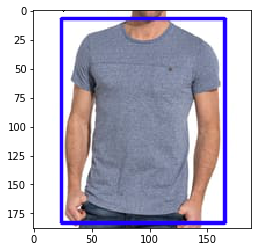

HUMAIN. Pourcentage obtenu par l'algorithme :  99.84292984008789


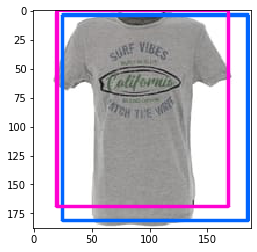

NON-HUMAIN. Pourcentage obtenu par l'algorithme :  33.15943479537964


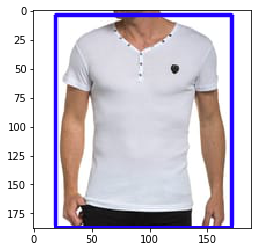

HUMAIN. Pourcentage obtenu par l'algorithme :  99.92740154266357


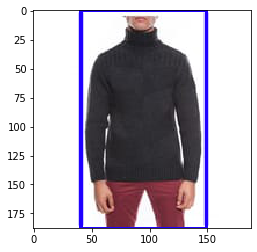

HUMAIN. Pourcentage obtenu par l'algorithme :  96.648108959198


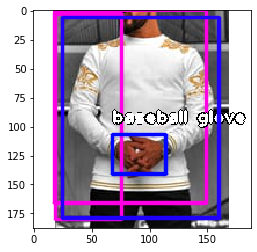

HUMAIN. Pourcentage obtenu par l'algorithme :  99.51257109642029


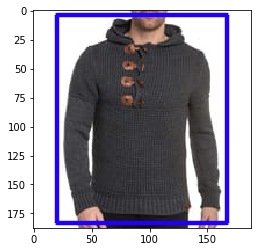

HUMAIN. Pourcentage obtenu par l'algorithme :  99.8888909816742


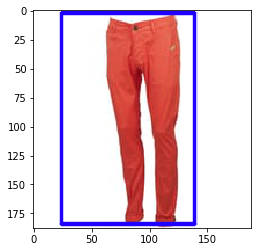

NON-HUMAIN. Pourcentage obtenu par l'algorithme :  84.4603955745697


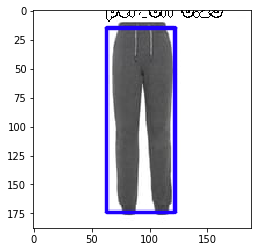

NON-HUMAIN. Pourcentage obtenu par l'algorithme :  24.95082914829254


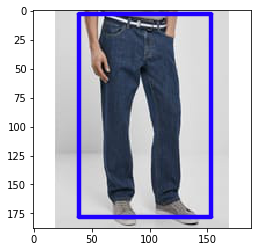

HUMAIN. Pourcentage obtenu par l'algorithme :  99.75717067718506


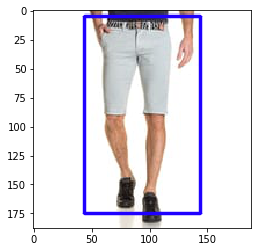

HUMAIN. Pourcentage obtenu par l'algorithme :  98.34252595901489


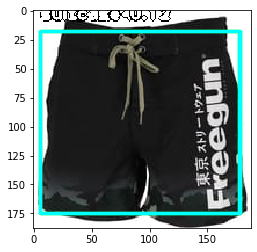

NON-HUMAIN. Pourcentage obtenu par l'algorithme :  14.348900318145752


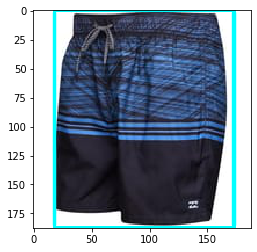

NON-HUMAIN. Pourcentage obtenu par l'algorithme :  11.192236095666885
Dans l'échantillon donné, il y a 58.333333333333336 % de photos sur fond blanc.


In [ ]:
tshirt_sample = random.sample(tshirt_path,3)
pull_sample = random.sample(pull_path,3)
pantalon_sample = random.sample(pantalon_path,3)
short_sample = random.sample(short_path,3)
sample = tshirt_sample + pull_sample + pantalon_sample + short_sample


pourcent_sample =  percentage_true_feedback(sample, is_human_model_feedback)
print("Dans l'échantillon donné, il y a",pourcent_sample ,"% de photos sur fond blanc.")

In [ ]:
#Environ 7 heures d'exécution. Vous pouvez retrouver les résultats que nous avons déjà calculé dans 
#la cellule en dessous.

print("Pourcentage de vêtements à modèle humain :\n")
percentage_human_model = percentage_true(all_path, is_human_model)


Pourcentage de T-shirts à logo :

10 images. Nous en sommes à : 0.28 % d'avancement.
20 images. Nous en sommes à : 0.56 % d'avancement.
30 images. Nous en sommes à : 0.84 % d'avancement.
40 images. Nous en sommes à : 1.12 % d'avancement.
50 images. Nous en sommes à : 1.4 % d'avancement.
60 images. Nous en sommes à : 1.68 % d'avancement.
70 images. Nous en sommes à : 1.96 % d'avancement.
80 images. Nous en sommes à : 2.24 % d'avancement.
90 images. Nous en sommes à : 2.52 % d'avancement.
100 images. Nous en sommes à : 2.8 % d'avancement.
110 images. Nous en sommes à : 3.08 % d'avancement.
120 images. Nous en sommes à : 3.36 % d'avancement.
130 images. Nous en sommes à : 3.64 % d'avancement.
140 images. Nous en sommes à : 3.92 % d'avancement.
150 images. Nous en sommes à : 4.2 % d'avancement.
160 images. Nous en sommes à : 4.48 % d'avancement.
170 images. Nous en sommes à : 4.76 % d'avancement.
180 images. Nous en sommes à : 5.04 % d'avancement.
190 images. Nous en sommes à : 5.32 % d'av

Nous avons laissé l'algorithme (très long) se terminer dans une autre instance de Notebook, voici le résultat obtenu :

<img src="https://i.imgur.com/cedpZuL.png" style="height:350px"> 

In [ ]:
?pie_chart_human_model

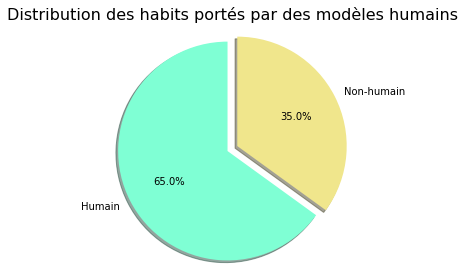

In [10]:
pie_chart_human_model ()

Au total, après calcul, nous avons trouvé donc **64.01%** de vêtements portés par des humains, ce qui là encore représente une part non-négligeable de la base de données, ce qui va fournir un cadre moins confortable pour l'apprentissage d'un algorithme de Deep Learning mais qui, on le verra, n'aura finalement pas tant d'impact.

# PARTIE 3 : Modelisation 

Notre démarche dans cette partie modelisation se veut fondamentalement scientifique. Elle se structure autour de la volonté d'atteindre un objectif simple : obtenir un modele avec les meilleures performances possibles dans la classification de categories de vetements que nous avons prédéfinies.

L'idée etant d'avoir une web app de *proof-of-concept* apportant une vraie valeur ajoutée *out-of-the-box*.

Tout au long de cette partie, nous utiliserons la librairie *fastai* construite sur *pytorch*

* Notre démarche se structurera, progressivement, autour de ces points:
  1. Choix du model - Elements Théoriques en faveur du CNN
  2. Stratégie d'optimisation du CNN - Transfert 
  Learning
  3. Acquisition des données - Preprocessing
  4. Apprentissage :
    * Premiere Iteration - Hyperparametres de bases
    * Deuxieme Iteration - Optimisation des hyperparametres
    * Iteration Finale - On exploite les caracteristiques de la derniere itération pour avoir des resultats finaux optimaux
  5. Export du modele pour le deployer au sein de la web app



## I - Convolutional Neural Networks : le standard des methodes de Deep Learning appliquée à la classification d'images

![Représentation d'un CNN](img_notebook/img3.jpeg)

Un *Convolutional Neural Network* (CNN) est un sous-ensemble des architectures neuronales profonde plus générale permettant le mapping entre features d'une donnée et sa classe.

Il s'avère que le CNN est une architecture conçu spécifiquement pour s'adapter de manière performantes aux données de type image. Elle ouvre  la possibilité d'un meilleur mapping entre features et classe des images de par une structure permettant l'apprentissage et la representation de caractéristiques d'un 'bas niveau' (au niveau des pixels de nos images de vetements) jusqu'a un 'haut niveau' ( contours des habits, formes, composition generale etc). Notre cas d'usage visant à la classification de different types d'images de vetements sied donc parfaitement à l'usage des CNN.

* L'architecture d'un CNN se décompose en un ensemble Feature Learning...
    1. "Ensemble Feature Learning' spécifique au CNN et donc au traitement des problème de Deep Learning sur des images: les deux éléments phares de ce sous-ensemble sont les transformations "convolution" et "pooling";
    2. La transformation de convolution est particulièrement adaptée puisque elle permet de gérer la "haute dimensionnalité" des répresentation informatique des images en tenseur, ici 32 par 32 par 32. ![DCNN1](img_notebook/img4.png)                                        Elle consiste seulement au dot product entre un filtre ( tenseur de paramètres à optimisées via gradient descent comme pour des NN classiques) et une portion de l'image originelle. Cette opération est répétée sur toutes où l'on peut possiblement projeter le filtre sur l'image jusqu'a obtenir une matrice donné appelée feature map.           ![DCNN2](img_notebook/img5.png)                                            On repète ce procédé avec différent filtres pour obtenir une couche de convolution entierement paramétrée. 
    3. La transformation dite Pooling permet de rédure la dimensionnalité de la réprésentation de l'image réduisant ainsi le nombre de paramètre et donc la puissance calculatoire necessaire. Cette transformation s'applique sur chaque feature map indépendamment. Le Max Pooling est une approche communément utilisée dont voici le fonctionnement.               
![DCNN3](img_notebook/img6.png)
    
    
* ... et un ensemble de Classification:
    1. Cet ensemble est complètement analogue aux *Neural Networks* classiques, sur chaque couches des neurones combines des tranformations paramétrées linéaires en entrée et non-linéaire en sortie (Relu, Sigmoïde etc)
    
    2. Une des différences clés c'esr que chaque neurones recoit une transformation linéaire de toutes les features des la couche précédente et donc des données alors que nous venons de montrer que pour la couche de convolution , chaque feature map ne reçoit qu'une partie de l'information de la donnée en entrée du CNN.


## II - Stratégie d'optimisation de notre CNN: Exploitation de la méthode du Transfert Learning

* Pour optimiser la performance de notre CNN à notre cas d'usage, nous n'allons pas nous contenter d'utiliser l'architecture de base.

![Representation Transfert Learning](img_notebook/cnn_rep_tl.png)

* Notre stratégie d'optimisation est d'utiliser la méthode du transfert learning. Celle-ci consiste à utiliser un modèle déjà pré-entrainer sur des données.Ici en l'occurence on utlise un modèle d'architecture **resnet50** qui déjà été entrainer sur plus de 1.5M d'images à catégoriser plus d'un milliers de classe. L'idée est de tirer profit de cette connaissance accumulée par le modèle, nottament sur les premieres couches du CNN qui contiennent les representation de 'bas niveau' et 'moyen niveau' du contenu d'une image.

![Fine Tuning](img_notebook/fine_tuning.png)



* On tire parti de ces connaisances en n'entrainant que les dernieres couches du CNN pré-entrainé en specifiant un output correspond à nos classes, le reste des couches etant "gelées'. La methode de fine-tuning que nous allons utilser va un peu plus loin en selectionnant au hasard une proportions de ces "couches savantes gelées" pour les réentrainées.


## III - Acquisition des données

### Imports

In [1]:
# Installation automatique de tous les modules necessaires au point fonctionnement du notebook
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 18.3MB/s 
     |████████████████████████████████| 1.1MB 51.8MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 194kB 62.8MB/s 
     |████████████████████████████████| 61kB 11.0MB/s 
Mounted at /content/gdrive


In [2]:
from fastai.vision.all import *

### Création de l'objet DataBlock 
* Détecte directement le jeu d'entrainement et de validation des données apres specification de ses caractéristiques, on choisira notamment:
  * Un split aléatoire (reproductible) 80/20 entre données *train* et *valid*
  * L'application d'une transformation sur les images pour avoir un format d'input uniforme (128x128 px)
* Labellisation des images automatique sur les différentes classes d'habits faite de par la présence des données dans des sous-répertoire éponymes ( permise par notre stratégie de *web-scraping*)


### Acces au repertoire d'intérêt

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
cd drive/MyDrive/ENSAE/

/content/drive/MyDrive/ENSAE


In [5]:
clothes_types = ['pantalon', 'pull', 'short','tshirt']
path = Path('python_project_dataset')

### Verification de la présence des données au sein du dataset

In [6]:
files = get_image_files(path)
files

(#3571) [Path('python_project_dataset/pantalon/h8c15536795779102.jpg'),Path('python_project_dataset/pantalon/h8b15492023812126.jpg'),Path('python_project_dataset/pantalon/hb416148784250910.jpg'),Path('python_project_dataset/pantalon/h3216189304569886.jpg'),Path('python_project_dataset/pantalon/hf216101675597854.jpg'),Path('python_project_dataset/pantalon/hfc16134277169182.jpg'),Path('python_project_dataset/pantalon/h9916148616151070.jpg'),Path('python_project_dataset/pantalon/h6215037063430174.jpg'),Path('python_project_dataset/pantalon/h5716298037903390.jpg'),Path('python_project_dataset/pantalon/hca15491522002974.jpg')...]

### Verification de la non corruption de ces images (pouvant arriver lors du *web-scraping*)

In [7]:
# toutes les données sont intègres : on va pouvoir les specifier notre objet DataBlock et les chargées.
corrupt = verify_images(files)
corrupt

(#0) []

### Specification de l'objet DataBlock

In [8]:
# (image data, label) key value pairing
# split 80/20, tfms resize 128x128 px
# seed pour la reproductibilité des résultats
clothes = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label,
        item_tfms=Resize(128)
        )

In [9]:
# chargement des données
dls = clothes.dataloaders(path)


### Visualisation de notre dataset
* Visualisation d'un segment aléatoire de nos données dans une matrice carrée de dimension (4,5)
* On peut vérifier qu'a chaque image est bien associé  correctement à son label

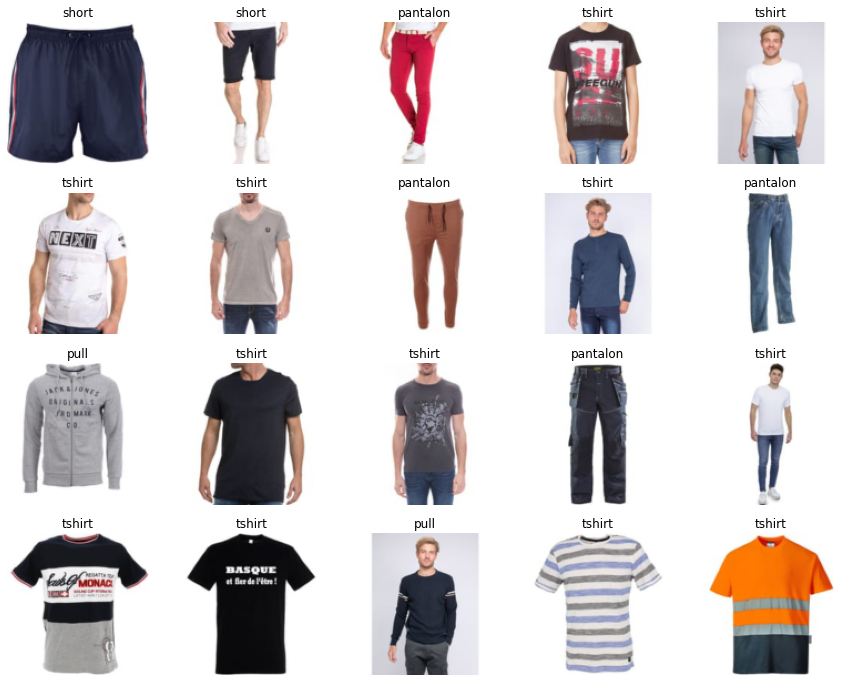

In [13]:
dls.show_batch(max_n=20)

### Preprocessing des données : procedure de Data Augmentation

* On augmente artificiellement la taille de notre dataset en incluant pour chaque images un ensemble de distorsions cadrées aleatoirement

* Cette procedure a de nombreux avantages, elle donne notamment lieu à la reduction de l'apprentissage du *bruit* present dans le training set pour se focaliser sur le *signal* : l'algorithme aura tendance a extraire les caracterisiques fondamentales permettant la reconnaissance d'un habit et sera moins sensible à l'angle de prise de vue.

In [14]:
# data augmentation
clothes = clothes.new(
                item_tfms=RandomResizedCrop(224, min_scale=0.5), 
                batch_tfms=aug_transforms(mult=2)
               )
dls = clothes.dataloaders(path)

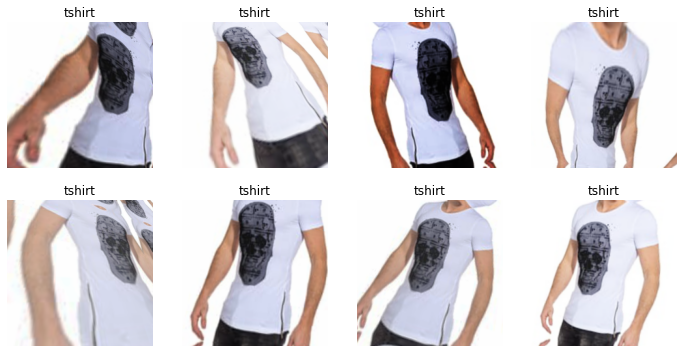

In [15]:
# visualisation d'une des 16 transformations pour une image du dataset
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## IV -  Apprentissage - Transfert Learning sur une architecture Resnet50

### Creation de l'objet learn
* Renferme l'architecture de notre modèle et permet de précharger les poids de restnet50
* Nous utiliserons :
  * l'approche *fine tune* expliquée en introduction de cette partie
  * la metrique *accuracy* pour la validation de nos resultats : proportion des images correctement labelisées au sein du *validation set*.
  * un callback pour evaluer plus finement les performances du modele ( notamment du point de vue de *l'overfitting*



In [17]:
from fastai.test_utils import *

In [19]:
learn = cnn_learner(dls,models.resnet50,metrics=accuracy,cbs=ShowGraphCallback())

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


### 1. Premiere itération - hyperparametres stocks


#### Caracteristiques de cette premiere itération

* On utilise la methode *fine tune*
* On fait 4 cycles sur les données c'est à dire 4 épochs
* Hyperparametres *stocks* du modele 

epoch,train_loss,valid_loss,accuracy,time
0,1.315817,0.570903,0.868347,00:30


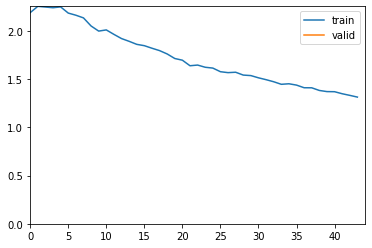

epoch,train_loss,valid_loss,accuracy,time
0,0.631898,0.365510,0.911765,00:39
1,0.452044,0.325604,0.910364,00:41
2,0.340050,0.224134,0.934174,00:41
3,0.266852,0.208754,0.941176,00:41


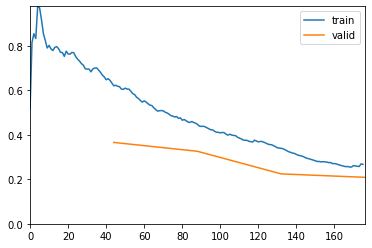

In [20]:
learn.fine_tune(4)

##### La perte sur le validation set est de manière consistante sous la perte sur le training set. Le modele à donc une excellente capacité de généralisation et n'overfit pas. **Le resultat de 94% d'accuracy est donc robuste.**



### 2. Deuxième itération - optimisation des hyperparametres



Nous cherchons à ameliorer encore nos resultats dejà excellents en tirant partie des methodes d'optimisation hyperparametrique.

#### Utilisation de la méthode de Smith  pour l'optimisation du learning rate

*taux d'apprentissage cycliques de Leslie Smith* implementé au sein de **fastai**

SuggestedLRs(lr_min=2.0892961401841602e-06, lr_steep=3.981071586167673e-06)

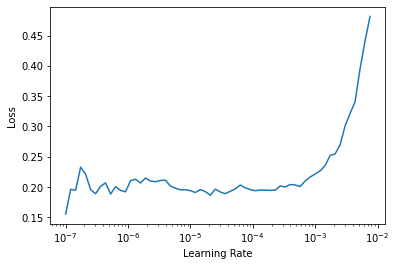

In [21]:
learn.lr_find()

Cette méthodologie vise à modifier notre CNN en lui attribuant un $lr$ qui change de manière cyclique pour chaque lot, au lieu d'un $lr$ non cyclique qui est soit constant, soit changeant à chaque epoch. Cet optimisateur nous suggere un taux de base $lr^{*} = 2.0892961401841602e-06$

#### On entraine desormais le modèle avec $lr^{*}$

* On utilise la methode *fine tune*
* On fait 4 cycles sur les données c'est à dire 4 épochs
* On intègre $lr^{*}$ en tant que learning rate 

epoch,train_loss,valid_loss,accuracy,time
0,0.223017,0.208435,0.941176,00:32


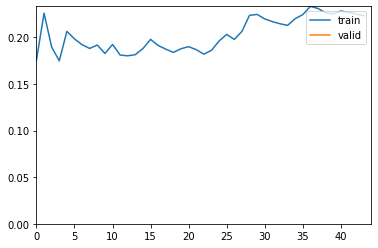

epoch,train_loss,valid_loss,accuracy,time
0,0.194639,0.201414,0.935574,00:41
1,0.208702,0.207216,0.939776,00:41
2,0.204908,0.202461,0.941176,00:41
3,0.192721,0.198424,0.936975,00:41


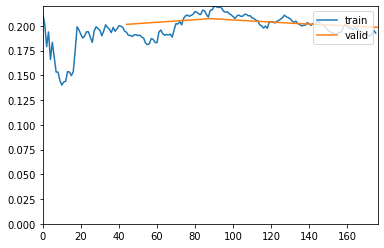

In [22]:
learn.fine_tune(4,base_lr=2.0892961401841602e-06)

On observe une amelioration marginale faible de nos resultats. On constate meme un léger overfiting. Il semblerait qu'on soit arriver aux limites d'amelioration.

#### Evaluation plus avancée des performances de cette deuxieme itération

In [23]:
interp = ClassificationInterpretation.from_learner(learn)

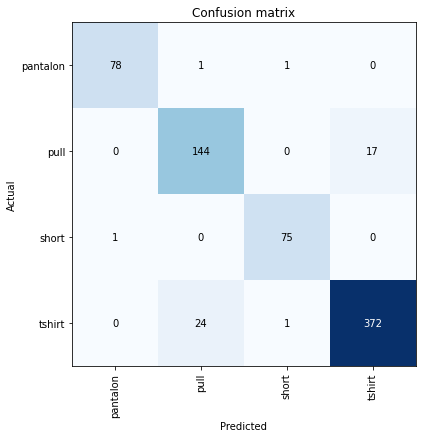

In [24]:
interp.plot_confusion_matrix(figsize=(6,6))

In [25]:
interp.most_confused()

[('tshirt', 'pull', 24),
 ('pull', 'tshirt', 17),
 ('pantalon', 'pull', 1),
 ('pantalon', 'short', 1),
 ('short', 'pantalon', 1),
 ('tshirt', 'short', 1)]

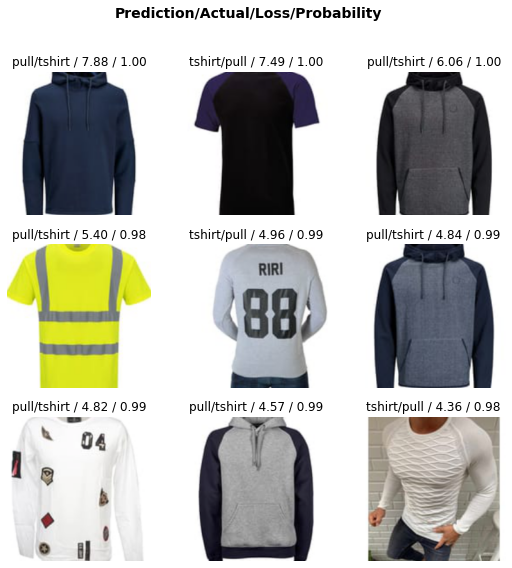

In [26]:
interp.plot_top_losses(9, nrows=3)

### 3. Itération finale - Nettoyage de la BDD + Optimisation des hyperparametres



### Acquisition des données nettoyée en conséquence + Preprocessing

In [34]:
clothes_types = ['pantalon', 'pull', 'short','tshirt']
path = Path('python_project_dataset_final')

In [35]:
files = get_image_files(path)
files

(#3500) [Path('python_project_dataset_final/pantalon/h5716298037903390.jpg'),Path('python_project_dataset_final/pantalon/h9916148616151070.jpg'),Path('python_project_dataset_final/pantalon/hca15491522002974.jpg'),Path('python_project_dataset_final/pantalon/hf216101675597854.jpg'),Path('python_project_dataset_final/pantalon/h6215037063430174.jpg'),Path('python_project_dataset_final/pantalon/h3216189304569886.jpg'),Path('python_project_dataset_final/pantalon/h8b15492023812126.jpg'),Path('python_project_dataset_final/pantalon/h8c15536795779102.jpg'),Path('python_project_dataset_final/pantalon/hfc16134277169182.jpg'),Path('python_project_dataset_final/pantalon/hb416148784250910.jpg')...]

In [36]:
# (image data, label) key value pairing
# split 80/20, tfms resize 128x128 px
# seed pour la reproductibilité des résultats
clothes = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label,
        item_tfms=Resize(128)
        )

In [37]:
# chargement des données
dls = clothes.dataloaders(path)


In [38]:
# data augmentation
clothes = clothes.new(
                item_tfms=RandomResizedCrop(224, min_scale=0.5), 
                batch_tfms=aug_transforms(mult=2)
               )
dls = clothes.dataloaders(path)

In [39]:
learn = cnn_learner(dls,models.resnet50,metrics=accuracy,cbs=ShowGraphCallback())

#### Utilisation de la méthode de Smith  pour l'optimisation du learning rate

*taux d'apprentissage cycliques de Leslie Smith* implenté au sein de **fastai**

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0063095735386013985)

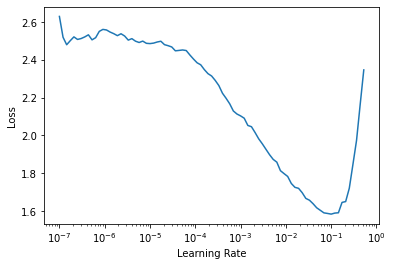

In [40]:
learn.lr_find()

#### On entraine desormais le modèle avec $lr^{*}$

* On utilise la methode *fine tune*
* On fait 4 cycles sur les données c'est à dire 4 épochs
* On intègre $lr^{*}$ en tant que learning rate 

epoch,train_loss,valid_loss,accuracy,time
0,1.040287,0.321716,0.900000,01:53


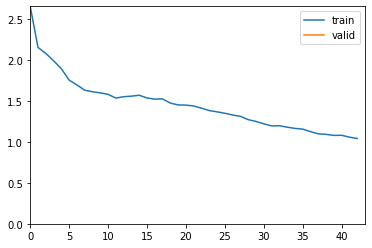

epoch,train_loss,valid_loss,accuracy,time
0,0.451639,0.238888,0.915714,00:41
1,0.357759,0.322649,0.920000,00:40
2,0.277911,0.175337,0.944286,00:40
3,0.201458,0.152863,0.948571,00:40


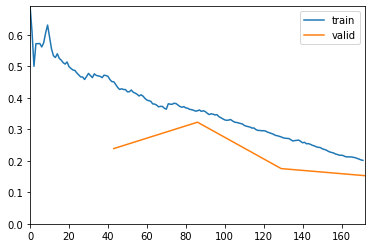

In [41]:
learn.fine_tune(4,base_lr=0.010000000149011612)

Nous tendons vers **95% d'accuracy** et ces resultats robustes. On pouura plus ameliorer grandement les resultats


## V - Export du meilleur modele en vue du deploiement sur la *web-app*


In [42]:
learn.export('export.pkl')

# PARTIE 4 : Architecture de la Web App

![Architecture Web App](img_notebook/web_app.png)

* Le schema ci-dessus represente l'architecture que nous avons mis en place pour permettre l'annotation en ligne des images de vetements. Cette application est conçue pour fonctionner à la fois sur smartphone et desktop/laptop.

* L'idée etant d'avoir une web app de *proof-of-concept* apportant une vraie valeur ajoutée *out-of-the-box*.

* La structure du projet est la suivante :

    1. Le code au sein du repository github est articulé au sein d'une image docker:
        * Dockerfile (contenant les instructions au server pour l'installation de l'environnement)
        * requierments.txt contenant les modules necessaires à l'inférence (fastai,pytorch) et au serveur (univicorn,starlette)
    2. Celle-ci se voit envoyée et deployée sur un serveur hebergé par render.
       (on passe les détails de mise en place qui sont besogneux)
    3. Lorsque le serveur est deployé, il sert la page d'accueil de AiDress et reste en attente d'une POST request contenant une image venant du formulaire d'analyse.
    4. L'image est reçue sur le serveur en BASE64, elle est convertie au format jpeg adequat et envoyée sur le modele prechargé pendant la phase d'initialisation.
    5. Le modele produit une inférence qui est renvoyée directement sur le front end via une POST request et affichée. L'utilisateur voit son image annotée !
